<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/Barrages_Turbine_Generator_Maps/Turbine_constrained_least_squares_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pylab import *
from sympy import Symbol,expand
%config InlineBackend.figure_formats = ['svg']

n11=Symbol('n_{11}')

In [2]:
import pathlib
if not pathlib.Path("Generator_Data_ElisabetaTedeschi.xlsx").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/TurbineHill_Data.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47121  100 47121    0     0   120k      0 --:--:-- --:--:-- --:--:--  119k


In [3]:
def LSQ_polyfit( NP, XL, XC_fun, XC_der ):
  
    ########################################################
    # LINEAR LEAST SQUARES PROBLEM
    #
    ( xl, yl ) = XL

    # Vandermonde matrix
    X = xl[:, None] ** np.arange( NP, -1, -1 )

    XTX = X.transpose().dot( X )
    XTy = X.transpose().dot( yl )

    # NO CONSTRAINTS IMPOSED => standard LSQ solution
    if XC_fun == None and XC_der == None:
      AA = XTX
      bb = XTy
      return np.linalg.solve( AA, bb )

    ########################################################
    # LAGRANGE MULTIPLIERS FOR CONSTRAINTS
    #
    if XC_fun != None:
      ( xc_fun, yc_fun ) = XC_fun 

      # function constraints
      xF = np.array( xc_fun ) 
      bF = np.array( yc_fun ) 

      # Vandermonde matrix
      AF = xF[:, None] ** np.arange( NP, -1, -1 )

    if XC_der != None:
      ( xc_der, yc_der ) = XC_der

      # derivative constraints
      xD = np.array( xc_der )
      bD = np.array( yc_der ) 

      # Derivative of the Vandermonde matrix
      AD = np.array( [  (i*xD**(i-1) if i > 0 else 0*xD) \
                        for i in range(NP,-1,-1) ] ).T

    if XC_fun != None and XC_der != None:
      Ac = np.block( [ [AF], [AD] ] )
      bc = np.block( [ bF, bD ] )
    elif XC_fun != None:
      Ac = AF
      bc = bF
    elif XC_der != None:
      Ac = AD
      bc = bD
      
    AcT = Ac.transpose()
    Z0 = np.zeros( ( Ac.shape[0], Ac.shape[0] ) )

    ########################################################
    # ASSEMBLE AND SOLVE GLOBAL SYSTEM
    #
    AA = np.block( [ [ XTX, AcT ], [ Ac, Z0 ] ] )
    bb = np.block( [ XTy, bc ] )
      
    alambda = np.linalg.solve( AA, bb )

    # final polynomial coeffs without lambdas
    return alambda[ 0:NP+1 ]

In [4]:
dfc = pd.read_excel( 'TurbineHill_Data.xlsx', 'flow_eta_max_power_dimless' )
n11_1 = np.array( dfc['n11_1'] )
Q11_1 = np.array( dfc['Q11_1'] )
eta_1 = np.array( dfc['eta_1'] ) / 100

n11_2 = np.array( dfc['n11_2'] )
Q11_2 = np.array( dfc['Q11_2'] )
eta_2 = np.array( dfc['eta_2'] ) / 100

n11_1 = np.array( n11_1[~np.isnan(n11_1)] )
Q11_1 = np.array( Q11_1[~np.isnan(Q11_1)] )
eta_1 = np.array( eta_1[~np.isnan(eta_1)] )

n11_2 = np.array( n11_2[~np.isnan(n11_2)] )
Q11_2 = np.array( Q11_2[~np.isnan(Q11_2)] )
eta_2 = np.array( eta_2[~np.isnan(eta_2)] )

0.169282*n_{11} + 0.089894

-0.0003639*n_{11}**3 + 0.0093768*n_{11}**2 - 0.0925874*n_{11} + 1.756872

(7.92193025936073,
 array([0.16928201, 0.08989368]),
 array([-3.63920467e-04,  9.37677379e-03, -9.25873626e-02,  1.75687197e+00]))

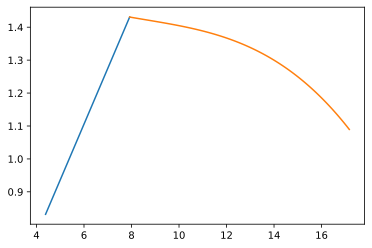

In [5]:
#plt.plot( n11_1, Q11_1, 'o' )
#plt.plot( n11_2, Q11_2, 'o' )

poly_Q11_1 = LSQ_polyfit( 1, ( n11_1, Q11_1 ), ([n11_1[-1]],[Q11_1[-1]]), None )
n11_1_plt = np.linspace( n11_1[0], n11_1[-1], 100 )
Q11_1_plt = np.polyval( poly_Q11_1, n11_1_plt )
plot( n11_1_plt, Q11_1_plt, '-' )

poly_Q11_2 = LSQ_polyfit( 3, ( n11_2, Q11_2 ), ([n11_2[0]],[Q11_2[0]]), None )
n11_2_plt = np.linspace( n11_2[0], n11_2[-1], 100 )
Q11_2_plt = np.polyval( poly_Q11_2, n11_2_plt )
plot( n11_2_plt, Q11_2_plt, '-' )

display( expand(np.poly1d( np.round( poly_Q11_1, 6 ) )(n11)) )
display( expand(np.poly1d( np.round( poly_Q11_2, 7 ) )(n11)) )
n11_2[0], poly_Q11_1, poly_Q11_2

-0.02076*n_{11}**2 + 0.20238*n_{11} + 0.48985

-0.00028*n_{11}**3 + 0.00205*n_{11}**2 + 0.00069*n_{11} + 0.79308

(7.92193025936073,
 array([-0.02076456,  0.20238444,  0.48984553]),
 array([-2.75685709e-04,  2.04822984e-03,  6.86081825e-04,  7.93083108e-01]),
 4.38213515707912,
 17.1681805419136)

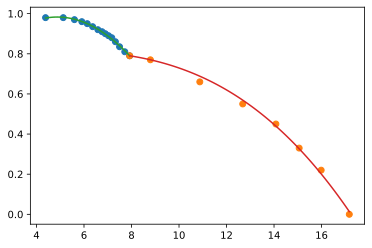

In [6]:
plt.plot( n11_1, eta_1, 'o' )
plt.plot( n11_2, eta_2, 'o' )

poly_eta_1 = LSQ_polyfit( 2, ( n11_1, eta_1 ), ([n11_1[-1]],[eta_1[-1]]), None )
n11_1_plt = np.linspace( n11_1[0], n11_1[-1], 100 )
eta_1_plt = np.polyval( poly_eta_1, n11_1_plt )
plot( n11_1_plt, eta_1_plt, '-' )

poly_eta_2 = LSQ_polyfit( 3, ( n11_2, eta_2 ), ([n11_2[0],n11_2[1]],[eta_2[0],eta_2[1]]), None )
n11_2_plt = np.linspace( n11_2[0], n11_2[-1], 100 )
eta_2_plt = np.polyval( poly_eta_2, n11_2_plt )
plot( n11_2_plt, eta_2_plt, '-' );

display( expand(np.poly1d( np.round( poly_eta_1, 5 ) )(n11)) )
display( expand(np.poly1d( np.round( poly_eta_2, 5 ) )(n11)) )
n11_2[0], poly_eta_1, poly_eta_2, n11_1[0], n11_2[-1]